In [1]:
import time
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt


import numpy as np
import gymnasium as gym
from gymnasium import spaces

class CustomCliffEnv(gym.Env):
    def __init__(self, rows=4, cols=12, P=1.0):
        super().__init__()
        self.nrow = rows
        self.ncol = cols
        self.start = (self.nrow - 1, 0)
        self.goal = (self.nrow - 1, self.ncol - 1)
        self.P = P
        self.state = self.start

        self.observation_space = spaces.Discrete(self.nrow * self.ncol)
        self.action_space = spaces.Discrete(4)  # 0: left, 1: down, 2: right, 3: up

        self.pos_to_state = lambda r, c: r * self.ncol + c
        self.state_to_pos = lambda s: (s // self.ncol, s % self.ncol)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = self.start
        return self._get_obs(), {}

    def _apply_action(self, action):
        r, c = self.state
        if np.random.rand() > self.P:
            action = np.random.choice([a for a in range(4) if a != action])
        if action == 0: c = max(0, c - 1)
        elif action == 1: r = min(self.nrow - 1, r + 1)
        elif action == 2: c = min(self.ncol - 1, c + 1)
        elif action == 3: r = max(0, r - 1)
        return r, c

    def step(self, action):
        r, c = self._apply_action(action)
        done = False

        
        if r == self.nrow - 1 and 0 < c < self.ncol - 1:
            reward = -100.0
            r, c = self.start  
        elif (r, c) == self.goal:
            reward = 10.0
            done = True
        else:
            reward = -1  

        self.state = (r, c)
        return self._get_obs(), reward, done, False, {}

    def _get_obs(self):
        r, c = self.state
        return self.pos_to_state(r, c)

    def render(self):
        grid = [["." for _ in range(self.ncol)] for _ in range(self.nrow)]
        for c in range(1, self.ncol - 1):
            grid[self.nrow - 1][c] = "C"
        r, c = self.state
        grid[r][c] = "A"
        grid[self.start[0]][self.start[1]] = "S"
        grid[self.goal[0]][self.goal[1]] = "G"
        print("\n".join(" ".join(row) for row in grid))
        print()


In [2]:

def get_policy(Q):
    return np.argmax(Q, axis=1)

def test(env, policy, episodes=100, max_steps=500):
    total_reward, total_steps = 0, 0
    for _ in range(episodes):
        state, _ = env.reset()
        done = False
        steps, reward_sum = 0, 0
        while not done and steps < max_steps:
            action = policy[state]
            state, reward, done, _, _ = env.step(action)
            reward_sum += reward
            steps += 1
        total_reward += reward_sum
        total_steps += steps
    print(f"Average episode length :{total_steps/episodes:.3f}")
    print(f"Average reward per episode :{total_reward/episodes:.3f}")

def plot_rewards(rewards, label):
    plt.plot(rewards, label=label)

def finalize_plot(title="Training Reward per Episode"):
    plt.title(title)
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [3]:


def Sarsa(env, episodes=1000, alpha=0.5, gamma=0.99, epsilon_start=1.0, epsilon_end=0.05):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []
    for ep in range(episodes):
        epsilon = max(epsilon_end, epsilon_start * (0.995 ** ep))
        state, _ = env.reset()
        action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
        total_reward = 0
        done = False
        while not done:
            next_state, reward, done, _, _ = env.step(action)
            total_reward += reward
            next_action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[next_state])
            Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])
            state, action = next_state, next_action
        rewards.append(total_reward)
    return Q, rewards

def Q_learning(env, episodes=1000, alpha=0.5, gamma=0.99, epsilon_start=1.0, epsilon_end=0.05):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []
    for ep in range(episodes):
        epsilon = max(epsilon_end, epsilon_start * (0.995 ** ep))
        state, _ = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, done, _, _ = env.step(action)
            total_reward += reward
            Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
            state = next_state
        rewards.append(total_reward)
    return Q, rewards

def Double_Q_learning(env, episodes=1000, alpha=0.5, gamma=0.99, epsilon_start=1.0, epsilon_end=0.05):
    Q1 = np.zeros((env.observation_space.n, env.action_space.n))
    Q2 = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []
    for ep in range(episodes):
        epsilon = max(epsilon_end, epsilon_start * (0.995 ** ep))
        state, _ = env.reset()
        total_reward = 0
        done = False
        while not done:
            Q_sum = Q1[state] + Q2[state]
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q_sum)
            next_state, reward, done, _, _ = env.step(action)
            total_reward += reward
            if np.random.rand() < 0.5:
                a_next = np.argmax(Q1[next_state])
                Q1[state, action] += alpha * (reward + gamma * Q2[next_state, a_next] - Q1[state, action])
            else:
                a_next = np.argmax(Q2[next_state])
                Q2[state, action] += alpha * (reward + gamma * Q1[next_state, a_next] - Q2[state, action])
            state = next_state
        rewards.append(total_reward)
    return Q1 + Q2, rewards



==== Custom Cliff Walking Training ====
Sarsa
Time taken by Sarsa :65.8501 seconds
Average episode length :500.000
Average reward per episode :-500.000
Q-learning
Time taken by Q-learning :2.5833 seconds
Average episode length :21.000
Average reward per episode :-10.000
Double Q-learning
Time taken by Double Q-learning :2.3377 seconds
Average episode length :21.000
Average reward per episode :-10.000


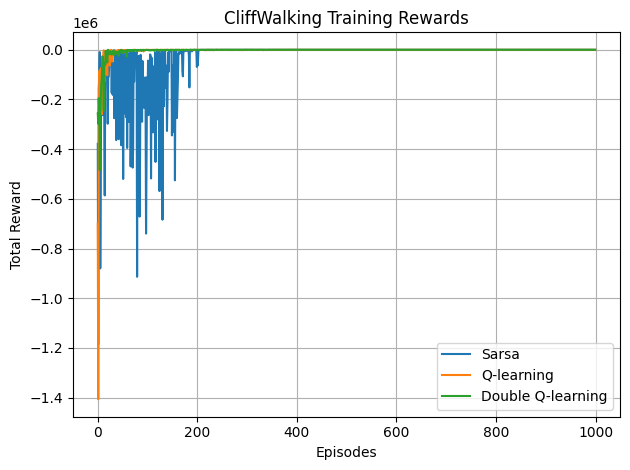

In [4]:
def run_and_report(env, algo_fn, name, episodes=1000, plot=True):
    print(name)
    start = time.time()
    Q, rewards = algo_fn(env, episodes)
    end = time.time()
    policy = get_policy(Q)
    print(f"Time taken by {name} :{end - start:.4f} seconds")
    test(env, policy)
    if plot:
        plot_rewards(rewards, name)
    return Q, rewards

env = CustomCliffEnv(rows=5, cols=20, P=1.0)
print("==== Custom Cliff Walking Training ====")
run_and_report(env, Sarsa, "Sarsa", 1000)
run_and_report(env, Q_learning, "Q-learning", 1000)
run_and_report(env, Double_Q_learning, "Double Q-learning", 1000)
finalize_plot("CliffWalking Training Rewards")
